In [1]:
#dezipe folder image
import zipfile

zip_path = 'meat_dataset.zip'      
extract_dir = 'images_dataset_meat'       

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
#verif nombre d'image par variable
import os

for category in ['fresh', 'spoiled']:
    path = os.path.join('images_dataset_meat', category)
    print(f"{category} : {len(os.listdir(path))} images")

fresh : 1801 images
spoiled : 1572 images


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import AUC, Precision, Recall
import datetime
import matplotlib.pyplot as plt

# 0️⃣ Configuration pour reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
# La ligne suivante peut causer des problèmes avec certaines versions de TF
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Configuration des paramètres
IMG_SIZE = (224, 224)  # Augmentation de la taille pour améliorer la précision
BATCH_SIZE = 32
EPOCHS_INITIAL = 15
EPOCHS_FINETUNE = 20
LEARNING_RATE_INITIAL = 1e-4
LEARNING_RATE_FINETUNE = 5e-5
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Configuration mémoire GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU disponible: {len(physical_devices)}")
    except:
        print("Erreur lors de la configuration GPU")
else:
    print("Pas de GPU disponible, utilisation du CPU")

# 1️⃣ Data Augmentation avancée
datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    fill_mode='nearest'
)

# Générateur de validation sans augmentation (sauf rescale)
datagen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Chargement des données
train_generator = datagen_train.flow_from_directory(
    'images_dataset_meat',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_generator = datagen_val.flow_from_directory(
    'images_dataset_meat',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Pour une évaluation cohérente
    seed=SEED
)

# Calculer les poids de classes pour gérer le déséquilibre
class_counts = np.bincount(train_generator.classes)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print(f"Distribution des classes: {class_counts}")
print(f"Poids des classes: {class_weights}")

# 2️⃣ Modèle DenseNet121 amélioré
base_model = DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # On fige les poids pour le premier entraînement

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 3️⃣ Compilation avec métriques avancées
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Résumé du modèle
model.summary()

# 4️⃣ Callbacks améliorés
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model_phase1.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# 5️⃣ Entraînement initial (feature extractor)
print("Phase 1: Entraînement en mode extraction de caractéristiques...")
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Chargement du meilleur modèle de phase 1
model = load_model(os.path.join(MODEL_DIR, 'best_model_phase1.h5'))

# 6️⃣ Fine-tuning : défreeze les couches de manière progressive
print("Phase 2: Fine-tuning du modèle...")
# Défreeze les 60 dernières couches du modèle
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

# Affiche les couches et leur état d'entraînabilité
print("Couches dégelées pour fine-tuning:")
for i, layer in enumerate(base_model.layers[-60:]):
    print(f"{i+len(base_model.layers)-60}. {layer.name}, trainable: {layer.trainable}")

# 7️⃣ Compilation pour fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINETUNE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Mise à jour des callbacks pour la phase 2
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model_final.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# 8️⃣ Entraînement fine-tuning
history_ft = model.fit(
    train_generator,
    epochs=EPOCHS_FINETUNE,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 9️⃣ Évaluation finale et visualisation
# Charger le meilleur modèle final
best_model = load_model(os.path.join(MODEL_DIR, 'best_model_final.h5'))

# Évaluer le modèle
evaluation = best_model.evaluate(val_generator, verbose=1)
print("Métriques finales:")
for i, metric_name in enumerate(best_model.metrics_names):
    print(f"{metric_name}: {evaluation[i]:.4f}")


Pas de GPU disponible, utilisation du CPU
Found 2699 images belonging to 2 classes.
Found 674 images belonging to 2 classes.
Distribution des classes: [1441 1258]
Poids des classes: {0: np.float64(0.936502428868841), 1: np.float64(1.0727344992050873)}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,181,889 (27.40 MB)

 Trainable params: 141,953 (554.50 KB)

 Non-trainable params: 7,039,936 (26.86 MB)

Phase 1: Entraînement en mode extraction de caractéristiques...


C:\Users\UTGR0501\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5488 - auc: 0.5757 - loss: 0.8319 - precision: 0.5041 - recall: 0.5412
Epoch 1: val_loss improved from None to 0.48478, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 650s 8s/step - accuracy: 0.5976 - auc: 0.6455 - loss: 0.7487 - precision: 0.5650 - recall: 0.5946 - val_accuracy: 0.7315 - val_auc: 0.9679 - val_loss: 0.4848 - val_precision: 1.0000 - val_recall: 0.4236 - learning_rate: 1.0000e-04
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7226 - auc: 0.7996 - loss: 0.5494 - precision: 0.6918 - recall: 0.7472
Epoch 2: val_loss improved from 0.48478 to 0.33190, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 721s 9s/step - accuracy: 0.7358 - auc: 0.8183 - loss: 0.5242 - precision: 0.6985 - recall: 0.7623 - val_accuracy: 0.8576 - val_auc: 0.9901 - val_loss: 0.3319 - val_precision: 0.9866 - val_recall: 0.7038 - learning_rate: 1.0000e-04
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7641 - auc: 0.8578 - loss: 0.4653 - precision: 0.7352 - recall: 0.7704
Epoch 3: val_loss improved from 0.33190 to 0.21156, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - accuracy: 0.7710 - auc: 0.8652 - loss: 0.4549 - precision: 0.7443 - recall: 0.7750 - val_accuracy: 0.9258 - val_auc: 0.9961 - val_loss: 0.2116 - val_precision: 0.9889 - val_recall: 0.8503 - learning_rate: 1.0000e-04
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8271 - auc: 0.9104 - loss: 0.3820 - precision: 0.7836 - recall: 0.8528
Epoch 4: val_loss improved from 0.21156 to 0.15469, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step - accuracy: 0.8314 - auc: 0.9130 - loss: 0.3757 - precision: 0.8067 - recall: 0.8394 - val_accuracy: 0.9555 - val_auc: 0.9973 - val_loss: 0.1547 - val_precision: 0.9931 - val_recall: 0.9108 - learning_rate: 1.0000e-04
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8568 - auc: 0.9323 - loss: 0.3366 - precision: 0.8257 - recall: 0.8608 
Epoch 5: val_loss improved from 0.15469 to 0.10991, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 1082s 13s/step - accuracy: 0.8629 - auc: 0.9364 - loss: 0.3249 - precision: 0.8447 - recall: 0.8649 - val_accuracy: 0.9733 - val_auc: 0.9979 - val_loss: 0.1099 - val_precision: 0.9933 - val_recall: 0.9490 - learning_rate: 1.0000e-04
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8649 - auc: 0.9390 - loss: 0.3168 - precision: 0.8444 - recall: 0.8760
Epoch 6: val_loss improved from 0.10991 to 0.07527, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 774s 9s/step - accuracy: 0.8785 - auc: 0.9479 - loss: 0.2959 - precision: 0.8544 - recall: 0.8911 - val_accuracy: 0.9852 - val_auc: 0.9982 - val_loss: 0.0753 - val_precision: 0.9903 - val_recall: 0.9777 - learning_rate: 1.0000e-04
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8923 - auc: 0.9623 - loss: 0.2532 - precision: 0.8665 - recall: 0.9102
Epoch 7: val_loss improved from 0.07527 to 0.07056, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 744s 9s/step - accuracy: 0.8918 - auc: 0.9615 - loss: 0.2551 - precision: 0.8681 - recall: 0.9054 - val_accuracy: 0.9837 - val_auc: 0.9983 - val_loss: 0.0706 - val_precision: 0.9903 - val_recall: 0.9745 - learning_rate: 1.0000e-04
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9005 - auc: 0.9613 - loss: 0.2531 - precision: 0.8959 - recall: 0.8928
Epoch 8: val_loss improved from 0.07056 to 0.05300, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 676s 8s/step - accuracy: 0.8966 - auc: 0.9625 - loss: 0.2505 - precision: 0.8870 - recall: 0.8919 - val_accuracy: 0.9896 - val_auc: 0.9986 - val_loss: 0.0530 - val_precision: 0.9904 - val_recall: 0.9873 - learning_rate: 1.0000e-04
Epoch 9/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9065 - auc: 0.9681 - loss: 0.2328 - precision: 0.8913 - recall: 0.9098
Epoch 9: val_loss improved from 0.05300 to 0.04266, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 695s 8s/step - accuracy: 0.9114 - auc: 0.9705 - loss: 0.2246 - precision: 0.9034 - recall: 0.9070 - val_accuracy: 0.9896 - val_auc: 0.9987 - val_loss: 0.0427 - val_precision: 0.9873 - val_recall: 0.9904 - learning_rate: 1.0000e-04
Epoch 10/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9159 - auc: 0.9732 - loss: 0.2120 - precision: 0.9082 - recall: 0.9142
Epoch 10: val_loss did not improve from 0.04266
85/85 ━━━━━━━━━━━━━━━━━━━━ 685s 8s/step - accuracy: 0.9170 - auc: 0.9748 - loss: 0.2072 - precision: 0.9045 - recall: 0.9189 - val_accuracy: 0.9911 - val_auc: 0.9987 - val_loss: 0.0428 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 11/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9209 - auc: 0.9794 - loss: 0.1896 - precision: 0.9023 - recall: 0.9301
Epoch 11: val_loss improved from 0.04266 to 0.04012, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 704s 8s/step - accuracy: 0.9185 - auc: 0.9766 - loss: 0.1975 - precision: 0.9067 - recall: 0.9197 - val_accuracy: 0.9911 - val_auc: 0.9988 - val_loss: 0.0401 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 12/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9177 - auc: 0.9792 - loss: 0.1904 - precision: 0.8898 - recall: 0.9371
Epoch 12: val_loss improved from 0.04012 to 0.03639, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 701s 8s/step - accuracy: 0.9222 - auc: 0.9776 - loss: 0.1923 - precision: 0.9062 - recall: 0.9293 - val_accuracy: 0.9911 - val_auc: 0.9987 - val_loss: 0.0364 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 13/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9213 - auc: 0.9786 - loss: 0.1923 - precision: 0.9183 - recall: 0.9162
Epoch 13: val_loss improved from 0.03639 to 0.03272, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 724s 9s/step - accuracy: 0.9248 - auc: 0.9771 - loss: 0.1974 - precision: 0.9163 - recall: 0.9229 - val_accuracy: 0.9911 - val_auc: 0.9989 - val_loss: 0.0327 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 14/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9308 - auc: 0.9771 - loss: 0.1925 - precision: 0.9265 - recall: 0.9303
Epoch 14: val_loss improved from 0.03272 to 0.03126, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 705s 8s/step - accuracy: 0.9278 - auc: 0.9787 - loss: 0.1878 - precision: 0.9149 - recall: 0.9316 - val_accuracy: 0.9911 - val_auc: 0.9987 - val_loss: 0.0313 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 15/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9394 - auc: 0.9863 - loss: 0.1545 - precision: 0.9316 - recall: 0.9404
Epoch 15: val_loss improved from 0.03126 to 0.03078, saving model to saved_models\best_model_phase1.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 699s 8s/step - accuracy: 0.9329 - auc: 0.9833 - loss: 0.1672 - precision: 0.9250 - recall: 0.9316 - val_accuracy: 0.9911 - val_auc: 0.9989 - val_loss: 0.0308 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


Phase 2: Fine-tuning du modèle...
Couches dégelées pour fine-tuning:
367. conv5_block8_2_conv, trainable: True
368. conv5_block8_concat, trainable: True
369. conv5_block9_0_bn, trainable: True
370. conv5_block9_0_relu, trainable: True
371. conv5_block9_1_conv, trainable: True
372. conv5_block9_1_bn, trainable: True
373. conv5_block9_1_relu, trainable: True
374. conv5_block9_2_conv, trainable: True
375. conv5_block9_concat, trainable: True
376. conv5_block10_0_bn, trainable: True
377. conv5_block10_0_relu, trainable: True
378. conv5_block10_1_conv, trainable: True
379. conv5_block10_1_bn, trainable: True
380. conv5_block10_1_relu, trainable: True
381. conv5_block10_2_conv, trainable: True
382. conv5_block10_concat, trainable: True
383. conv5_block11_0_bn, trainable: True
384. conv5_block11_0_relu, trainable: True
385. conv5_block11_1_conv, trainable: True
386. conv5_block11_1_bn, trainable: True
387. conv5_block11_1_relu, trainable: True
388. conv5_block11_2_conv, trainable: True
389. c

85/85 ━━━━━━━━━━━━━━━━━━━━ 748s 8s/step - accuracy: 0.9300 - auc: 0.9807 - loss: 0.1772 - precision: 0.9140 - recall: 0.9380 - val_accuracy: 0.9911 - val_auc: 0.9990 - val_loss: 0.0287 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 5.0000e-05
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9368 - auc: 0.9843 - loss: 0.1600 - precision: 0.9178 - recall: 0.9468
Epoch 2: val_loss improved from 0.02874 to 0.02746, saving model to saved_models\best_model_final.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 705s 8s/step - accuracy: 0.9337 - auc: 0.9831 - loss: 0.1660 - precision: 0.9218 - recall: 0.9372 - val_accuracy: 0.9926 - val_auc: 0.9991 - val_loss: 0.0275 - val_precision: 0.9874 - val_recall: 0.9968 - learning_rate: 5.0000e-05
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9515 - auc: 0.9889 - loss: 0.1385 - precision: 0.9393 - recall: 0.9576
Epoch 3: val_loss did not improve from 0.02746
85/85 ━━━━━━━━━━━━━━━━━━━━ 675s 8s/step - accuracy: 0.9407 - auc: 0.9852 - loss: 0.1561 - precision: 0.9243 - recall: 0.9507 - val_accuracy: 0.9911 - val_auc: 0.9990 - val_loss: 0.0279 - val_precision: 0.9873 - val_recall: 0.9936 - learning_rate: 5.0000e-05
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9250 - auc: 0.9813 - loss: 0.1751 - precision: 0.9182 - recall: 0.9223
Epoch 4: val_loss did not improve from 0.02746
85/85 ━━━━━━━━━━━━━━━━━━━━ 710s 8s/step - accuracy: 0.9274 - auc: 0.9833 - loss: 0.1665 - precision: 0.9214 - recall: 0.92

22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.9926 - auc: 0.9991 - loss: 0.0275 - precision: 0.9874 - recall: 0.9968
Métriques finales:
loss: 0.0275
compile_metrics: 0.9926


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

Modèle sauvegardé dans saved_models\meat_classifier_model


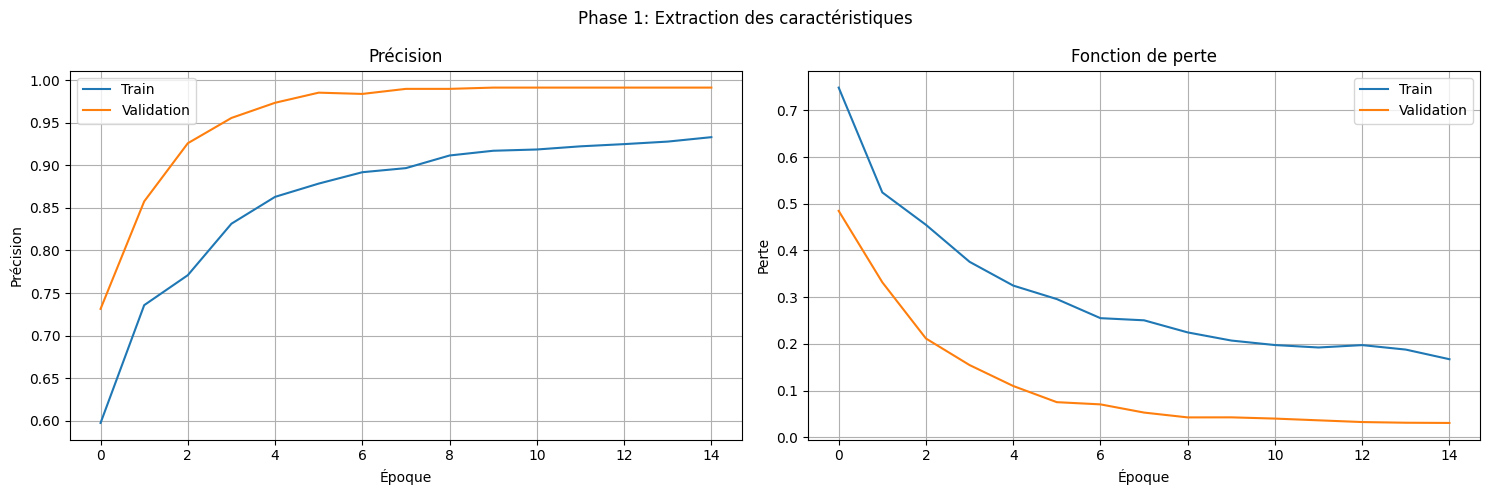

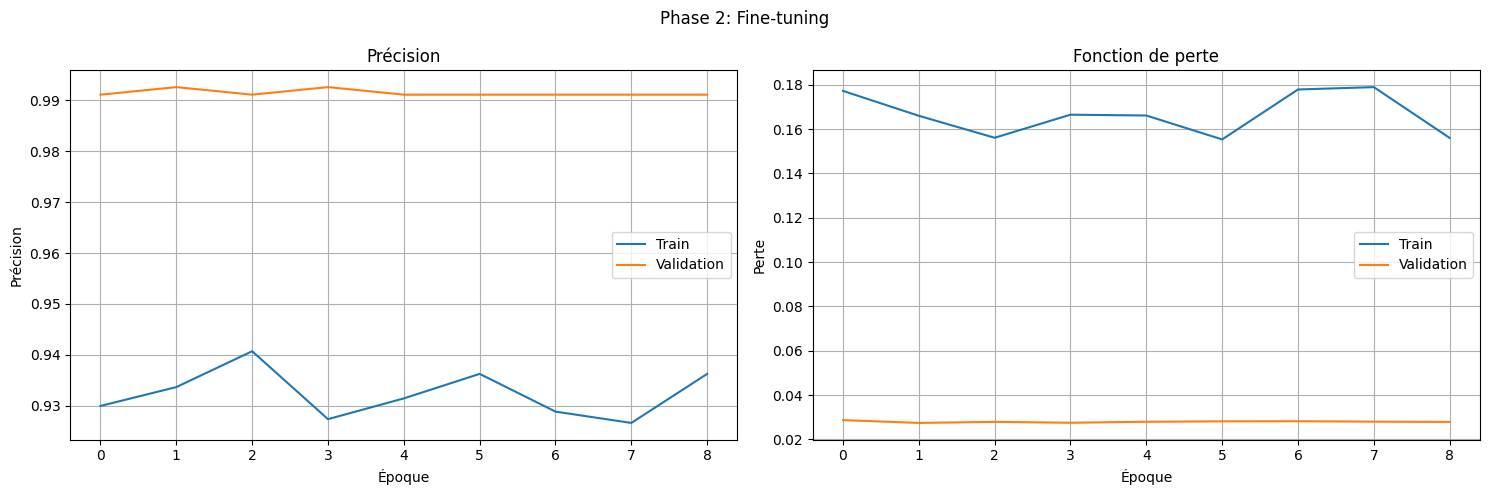

Entraînement terminé!


In [11]:

# Sauvegarder le modèle au format TensorFlow SavedModel (plus flexible)
save_model(
    best_model, 
    os.path.join(MODEL_DIR, 'meat_classifier_model.keras')
)
print(f"Modèle sauvegardé dans {os.path.join(MODEL_DIR, 'meat_classifier_model')}")

# Fonction pour tracer l'historique d'entraînement
def plot_training_history(history, title="Métriques d'entraînement"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Précision
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Précision')
    ax1.set_ylabel('Précision')
    ax1.set_xlabel('Époque')
    ax1.legend()
    ax1.grid(True)
    
    # Perte
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Fonction de perte')
    ax2.set_ylabel('Perte')
    ax2.set_xlabel('Époque')
    ax2.legend()
    ax2.grid(True)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, f"{title.lower().replace(' ', '_')}.png"))
    plt.show()

# Tracer les historiques d'entraînement
plot_training_history(history, "Phase 1: Extraction des caractéristiques")
plot_training_history(history_ft, "Phase 2: Fine-tuning")

print("Entraînement terminé!")

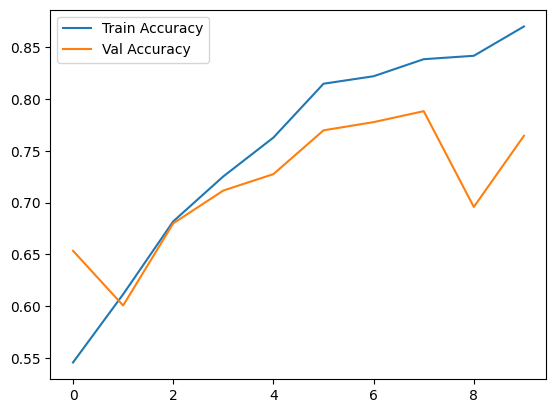

In [5]:
#visualisation
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [6]:
#calcul de l'accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 796ms/step - accuracy: 0.8413 - loss: 0.3487
Validation accuracy: 0.84


In [7]:
#-----------------------------------#
#prédiction sur de nouvelles images : 
#-----------------------------------#
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'images_dataset_meat/Spoiled/test_20171017_230521D.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print('Fresh' if prediction[0][0] < 0.5 else 'Spoiled')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Spoiled


In [1]:
#sauvegarde du modèle
model.save('meat_fresh_model.h5')


NameError: name 'model' is not defined

In [ ]:
#pour recharger le modèle
##########################
from tensorflow.keras.models import load_model
model = load_model('meat_fresh_model.keras')

In [ ]:
import matplotlib.pyplot as plt

img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.title(f"Prédiction : {'Fresh' if prediction[0][0] < 0.5 else 'Spoiled'}", fontsize=16, color='green' if prediction[0][0] < 0.5 else 'red')
plt.axis('off')
plt.show()

In [ ]:
#dashboard interractif streamlite
#import streamlit as st
#from tensorflow.keras.preprocessing import image
#import numpy as np

#st.title("Classificateur de viande : Fresh vs Spoiled")

#uploaded_file = st.file_uploader("Choisis une image...", type=["jpg", "jpeg", "png"])
#if uploaded_file is not None:
 #   img = image.load_img(uploaded_file, target_size=(128, 128))
  #  st.image(img, caption='Image chargée', use_column_width=True)
   # img_array = image.img_to_array(img) / 255.0
    #img_array = np.expand_dims(img_array, axis=0)
    #prediction = model.predict(img_array)
    #label = 'Fresh' if prediction[0][0] < 0.5 else 'Spoiled'
    #st.markdown(f"### Prédiction : {label}")